In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from scipy.optimize import fsolve
from scipy import special # bessel functions 
from matplotlib import gridspec
from matplotlib.legend import Legend
import healpy as hp
import time  # temp timer 
import cnb_utils as uts
import importlib

%config InlineBackend.figure_format = 'retina' 

In [2]:
# constants 
h = 0.67
c = 299793.
H0 = 100*h
omega_m = 0.27 + 0.049
omega_rad = 2.47e-05/(h*h)
omega_lambda = 1 - omega_m - omega_rad

T_nu = 2.7255*(4/11)**(1/3)*(3.046/3)**(1/4)
k_B = 8.617333e-05 # eV/K
a_ndec = 1e-10

massless_cutoff = 2e-5   # below this, we consider neutrinos to be massless
scaling = 1e12  # for scaling cl to the correct unit/magnitude 

colors = ["#C74804", "#66bda5", "#CC78BC", "#DE8F05", "#0173B2"]

In [3]:
# changing variables 
q_i = 1  # placeholder q index 0=1.5 (max q/n_qbins),1=3.0,2=4.5,3=6.0,4=7.5,5=9.0,6=10.5,7=12.0,8=13.5,9=15.0

# relevant values for running the functions 
l_min = 1
l_max = 50
ls = np.arange(l_min, l_max+1, 1)

nu_masses_str = ['0.00001','0.01', '0.05'] 
m1, m2, m3 = float(nu_masses_str[0]), float(nu_masses_str[1]), float(nu_masses_str[2])
nu_masses = [m1, m2, m3]  # eV
k_min, k_max = 1e-4, 1e-1     # 1/Mpc
n_kmodes = 200
k_magnitudes_full = np.logspace(np.log(k_min), np.log(k_max), n_kmodes, base=np.e)
l_max_ncdm = 50
n_qbins = 10
uts.n_qbins = n_qbins

As_default = 2.215e-9
pivot_default = 5e-2
pivot = 5e-4 
ns = 0.9619
As = As_default*(pivot/pivot_default)**(ns-1)

# params just to get the transfer functions since the args to get the earliest transfer affect the perturbations
params_tf = {
    # Output
    'output'         : 'dTk', 
    'k_output_values': list(k_magnitudes_full),
    'P_k_max_1/Mpc'  : 0,
    # Basic cosmology
    'H0'       : 67,
    'Omega_b'  : 0.049,
    'Omega_cdm': 0.27,
    'n_s': ns,
    # Add neutrino hierarchy
    'N_ur'    : 0,
    'N_ncdm'  : 3,
    'm_ncdm'  : nu_masses,
    'T_ncdm'  : [(4/11)**(1/3)*(3.046/3)**(1/4)]*3,  # Ensure N_eff = 3.046
    # Neutrino precision parameters
    'ncdm_fluid_approximation': 3,
    'Quadrature strategy'     : [3]*3,
    'l_max_ncdm'              : l_max_ncdm,
    'Number of momentum bins' : [n_qbins]*3,
    'Maximum q'               : [15]*3,
    # Photon temperature and precision parameters
    'T_cmb'                            : 2.7255,
    'radiation_streaming_approximation': 3,
    'l_max_g'                          : 1000,
    'l_max_pol_g'                      : 1000,
    # General precision parameters
    'evolver'                     : 0,
    'z_max_pk': 45999,
    'recfast_Nz0'                 : 1e5,
    'recfast_z_initial': 46001,
    'tol_thermo_integration'      : 1e-6,
    'perturb_integration_stepsize': 0.025,
    # add for phi_prime
    'extra metric transfer functions':'y',
    'gauge':'newtonian',
}


params = {
    # Output
    'output'         : 'dTk',
    'k_output_values': list(k_magnitudes_full),
    'P_k_max_1/Mpc'  : 0,
    # Basic cosmology
    'H0'       : 67,
    'Omega_b'  : 0.049,
    'Omega_cdm': 0.27,
    'n_s': ns,
    # Add neutrino hierarchy
    'N_ur'    : 0,
    'N_ncdm'  : 3,
    'm_ncdm'  : nu_masses,
    'T_ncdm'  : [(4/11)**(1/3)*(3.046/3)**(1/4)]*3,  # Ensure N_eff = 3.046
    # Neutrino precision parameters
    'ncdm_fluid_approximation': 3,
    'Quadrature strategy'     : [3]*3,
    'l_max_ncdm'              : l_max_ncdm,
    'Number of momentum bins' : [n_qbins]*3,
    'Maximum q'               : [15]*3,
    # Photon temperature and precision parameters
    'T_cmb'                            : 2.7255,
    'radiation_streaming_approximation': 3,
    'l_max_g'                          : 1000,
    'l_max_pol_g'                      : 1000,
    # General precision parameters
    'evolver'                     : 0,
    'recfast_Nz0'                 : 1e+5,
    'tol_thermo_integration'      : 1e-6,
    'perturb_integration_stepsize': 0.025,
    # add for phi_prime
    'extra metric transfer functions':'y',
    'gauge':'newtonian',
}

for key, val in params_tf.copy().items():
    if isinstance(val, list):
        params_tf[key] = str(val).strip('[]')

for key, val in params.copy().items():
    if isinstance(val, list):
        params[key] = str(val).strip('[]')

In [4]:
_, _, tf = uts.run_class(params_tf, True)

--- 848.7475407123566 seconds ---


In [5]:
pts_full, tau_0_full = uts.run_class(params, False)

--- 940.2610518932343 seconds ---


In [6]:
nu_masses_str2 = ['0.05', '0.06', '0.1']
nu_masses2 = np.array(nu_masses_str2).astype(np.float)
params_tf['m_ncdm'] = str(list(nu_masses2)).strip('[]')

_, _, tf_m2 = uts.run_class(params_tf, True)

--- 676.4055564403534 seconds ---


In [7]:
params['m_ncdm'] = str(list(nu_masses2)).strip('[]')

pts_m2, tau_0_m2 = uts.run_class(params, False)

--- 896.0239975452423 seconds ---


In [8]:
clslos0_full = uts.get_clq_LoS(0, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, ls, tau_0_full, np.infty)   
clslos1_full = uts.get_clq_LoS(1, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, ls, tau_0_full, np.infty)
clslos2_full = uts.get_clq_LoS(2, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, ls, tau_0_full, np.infty)

clsbh0_full, clsbh1_full, clsbh2_full = uts.get_clq_BH(q_i, pts_full, k_magnitudes_full, ls, True, ns)

In [9]:
clslos0_m2 = uts.get_clq_LoS(0, q_i, pts_m2, tf_m2, nu_masses2, True, k_magnitudes_full, ls, tau_0_m2, np.infty)   
clslos1_m2 = uts.get_clq_LoS(1, q_i, pts_m2, tf_m2, nu_masses2, True, k_magnitudes_full, ls, tau_0_m2, np.infty)
clslos2_m2 = uts.get_clq_LoS(2, q_i, pts_m2, tf_m2, nu_masses2, True, k_magnitudes_full, ls, tau_0_m2, np.infty)

clsbh0_m2, clsbh1_m2, clsbh2_m2 = uts.get_clq_BH(q_i, pts_m2, k_magnitudes_full, ls, True, ns)

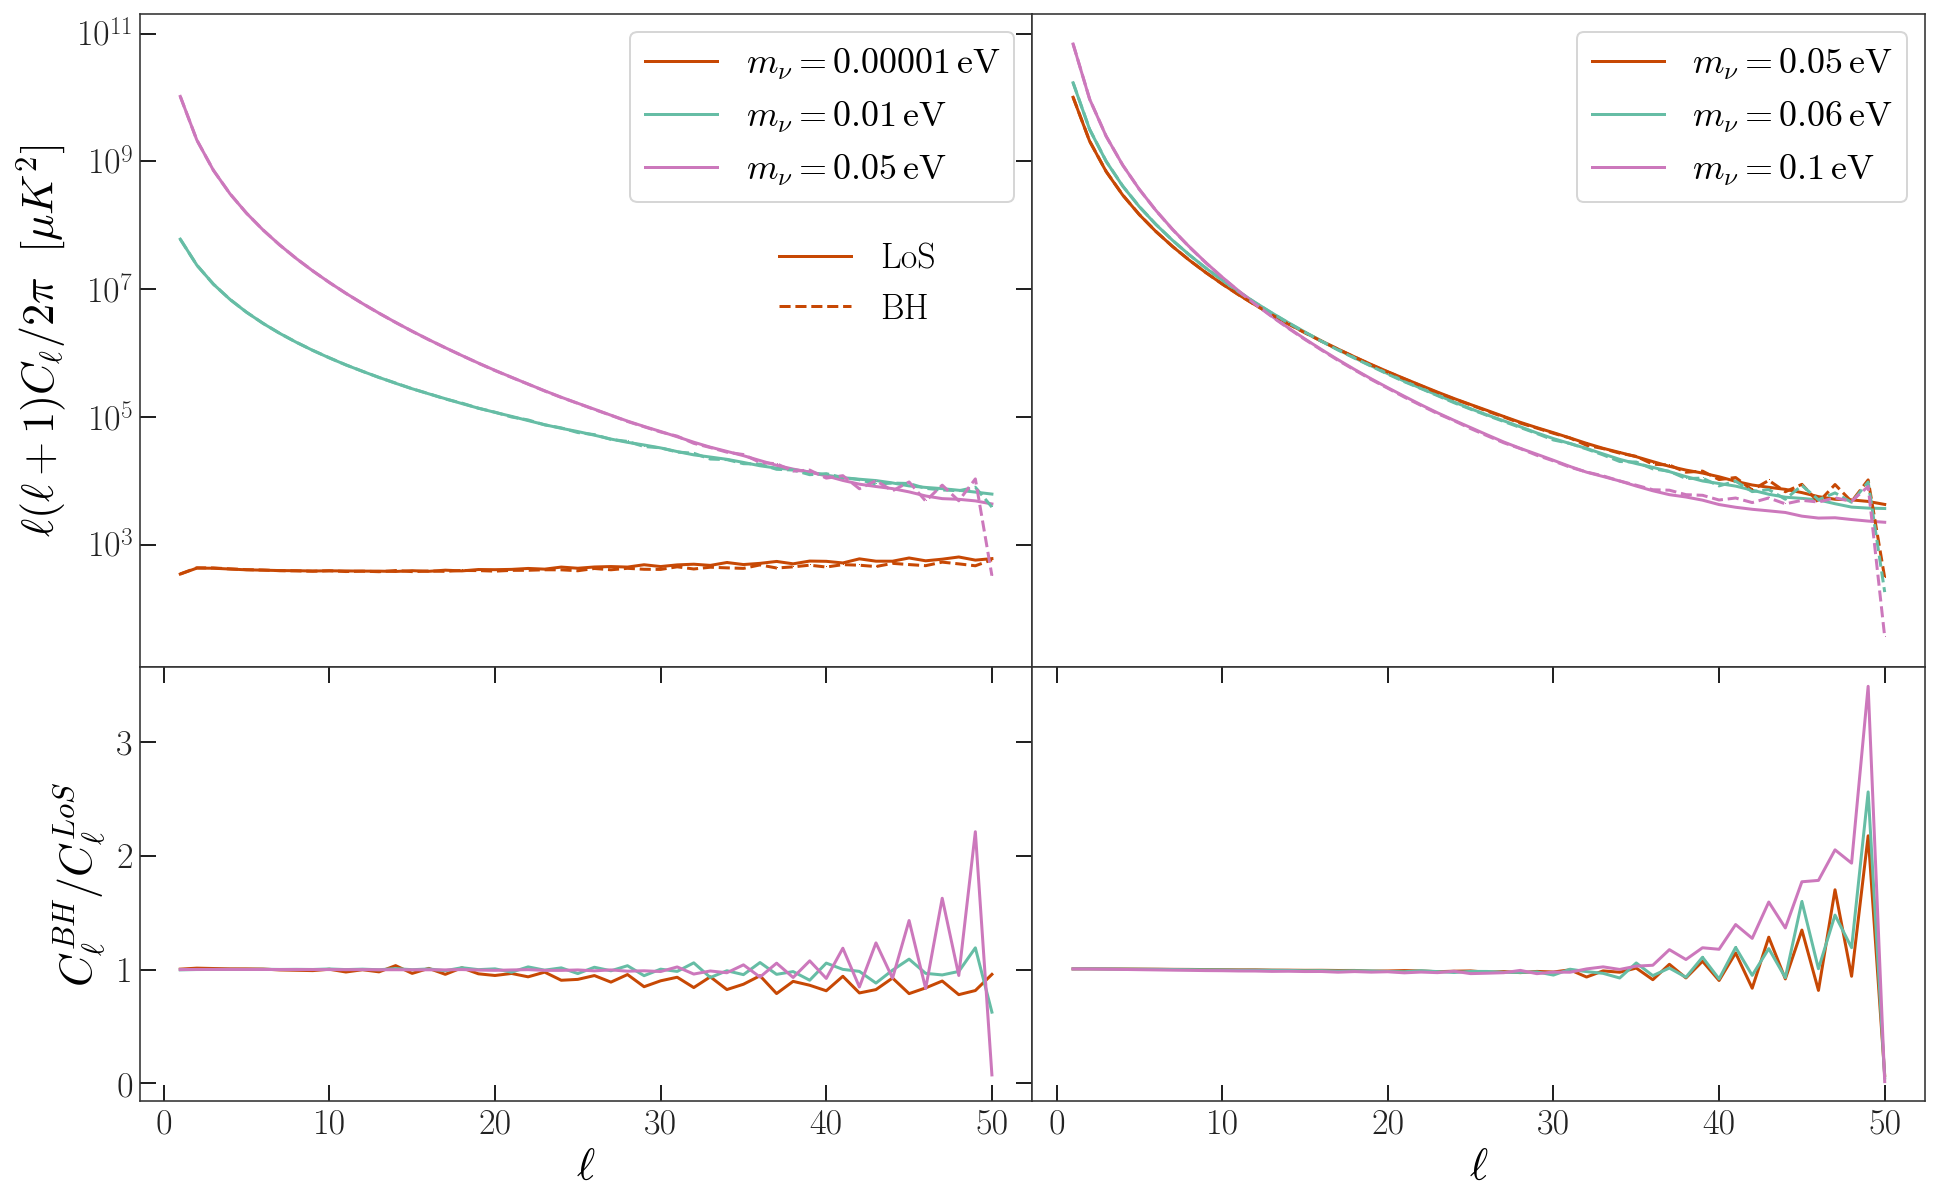

In [10]:
# adjust row widths of the subplots 
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2])

f = plt.figure(figsize=(16,10))
ax1 = f.add_subplot(gs[0,0])
ax2 = f.add_subplot(gs[1,0], sharex=ax1)
ax3 = f.add_subplot(gs[0,1], sharey=ax1)
ax4 = f.add_subplot(gs[1,1], sharex=ax3, sharey=ax2)

plots = [] # for second legend 

plots += ax1.semilogy(ls, ls*(ls+1)*clslos0_full/(2.0*np.pi), color=colors[0], marker=',', 
                     label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[0]))
ax1.semilogy(ls, ls*(ls+1)*clslos1_full/(2.0*np.pi), color=colors[1], marker=',',
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[1]))
ax1.semilogy(ls, ls*(ls+1)*clslos2_full/(2.0*np.pi), color=colors[2], marker=',',
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[2]))

plots += ax1.semilogy(ls, ls*(ls+1)*clsbh0_full/(2.0*np.pi), color=colors[0], marker=',', linestyle='--')
ax1.semilogy(ls, ls*(ls+1)*clsbh1_full/(2.0*np.pi), color=colors[1], marker=',', linestyle='--')
ax1.semilogy(ls, ls*(ls+1)*clsbh2_full/(2.0*np.pi), color=colors[2], marker=',', linestyle='--')
ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi \ \ [\mu K^2]$')
ax1.legend()

ax2.plot(ls, clsbh0_full/clslos0_full, color=colors[0], marker=',', 
         label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[0]))
ax2.plot(ls, clsbh1_full/clslos1_full, color=colors[1], marker=',',
         label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[1]))
ax2.plot(ls, clsbh2_full/clslos2_full, color=colors[2], marker=',',
         label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[2]))
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$C_\ell^{BH}/C_\ell^{LoS}$')

ax3.semilogy(ls, ls*(ls+1)*clslos0_m2/(2.0*np.pi), color=colors[0], marker=',', 
                     label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str2[0]))
ax3.semilogy(ls, ls*(ls+1)*clslos1_m2/(2.0*np.pi), color=colors[1], marker=',',
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str2[1]))
ax3.semilogy(ls, ls*(ls+1)*clslos2_m2/(2.0*np.pi), color=colors[2], marker=',',
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str2[2]))
ax3.semilogy(ls, ls*(ls+1)*clsbh0_m2/(2.0*np.pi), color=colors[0], marker=',', linestyle='--')
ax3.semilogy(ls, ls*(ls+1)*clsbh1_m2/(2.0*np.pi), color=colors[1], marker=',', linestyle='--')
ax3.semilogy(ls, ls*(ls+1)*clsbh2_m2/(2.0*np.pi), color=colors[2], marker=',', linestyle='--')
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.legend()

ax4.plot(ls, clsbh0_m2/clslos0_m2, color=colors[0], marker=',', 
         label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[0]))
ax4.plot(ls, clsbh1_m2/clslos1_m2, color=colors[1], marker=',',
         label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[1]))
ax4.plot(ls, clsbh2_m2/clslos2_m2, color=colors[2], marker=',',
         label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[2]))
ax4.set_xlabel(r'$\ell$')
ax4.yaxis.set_visible(False)

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

leg = Legend(ax1, plots, ['LoS', 'BH'], loc=[0.7,0.5], frameon=False)
ax1.add_artist(leg) 

In [11]:
l_test = 1
dcl_dlnks_2 = uts.get_dcl_dlnk(2, q_i, l_test, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)
dcl_dlnks_1 = uts.get_dcl_dlnk(1, q_i, l_test, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)
dcl_dlnks_0 = uts.get_dcl_dlnk(0, q_i, l_test, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)

l_test2 = 2 
dcl2_dlnks_2 = uts.get_dcl_dlnk(2, q_i, l_test2, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)
dcl2_dlnks_1 = uts.get_dcl_dlnk(1, q_i, l_test2, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)
dcl2_dlnks_0 = uts.get_dcl_dlnk(0, q_i, l_test2, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)

l_test3 = 15 
dcl3_dlnks_2 = uts.get_dcl_dlnk(2, q_i, l_test3, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)
dcl3_dlnks_1 = uts.get_dcl_dlnk(1, q_i, l_test3, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)
dcl3_dlnks_0 = uts.get_dcl_dlnk(0, q_i, l_test3, pts_full, tf, nu_masses, k_magnitudes_full, tau_0_full)

Text(0.5, 1.0, '$l = 15$')

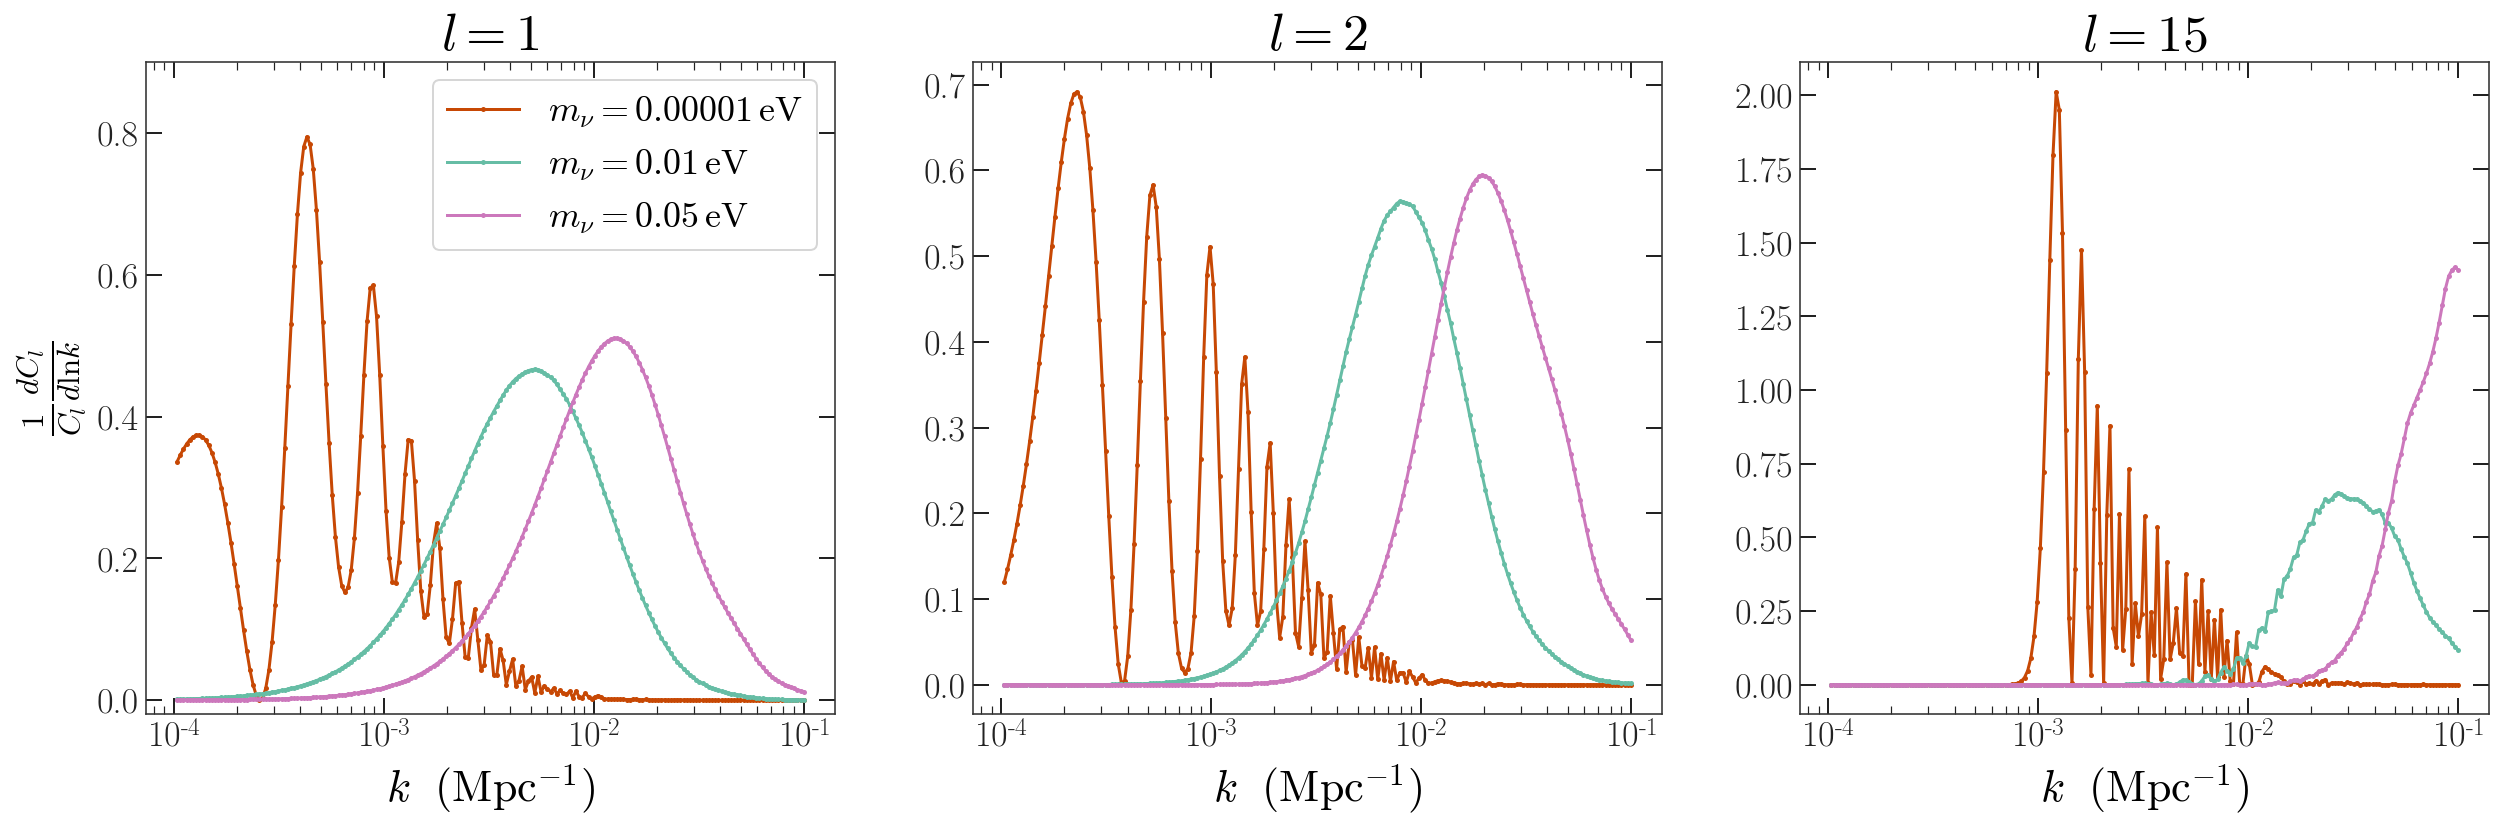

In [12]:
gs = gridspec.GridSpec(1, 3)

f = plt.figure(figsize=(21,6))
ax1 = f.add_subplot(gs[:,0])
ax2 = f.add_subplot(gs[:,1])
ax3 = f.add_subplot(gs[:,2])

ax1.semilogx(k_magnitudes_full[1:], dcl_dlnks_0/clslos0_full[l_test-1], color=colors[0],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[0]))
ax1.semilogx(k_magnitudes_full[1:], dcl_dlnks_1/clslos1_full[l_test-1], color=colors[1],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[1]))
ax1.semilogx(k_magnitudes_full[1:], dcl_dlnks_2/clslos2_full[l_test-1], color=colors[2],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[2]))
ax1.set_xlabel(r'$k\ \ (\mathrm{Mpc}^{-1})$')
ax1.set_ylabel(r'$\frac{1}{C_l}\frac{dC_l}{d\ln k}$')
ax1.set_ylim(-0.02, 0.9)
ax1.set_title(r'$l = {}$'.format(l_test))
ax1.legend(loc='upper right')

ax2.semilogx(k_magnitudes_full[1:], dcl2_dlnks_0/clslos0_full[l_test2-1], color=colors[0],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[0]))
ax2.semilogx(k_magnitudes_full[1:], dcl2_dlnks_1/clslos1_full[l_test2-1], color=colors[1],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[1]))
ax2.semilogx(k_magnitudes_full[1:], dcl2_dlnks_2/clslos2_full[l_test2-1], color=colors[2],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[2]))
ax2.set_xlabel(r'$k\ \ (\mathrm{Mpc}^{-1})$')
ax2.set_title(r'$l = {}$'.format(l_test2))

ax3.semilogx(k_magnitudes_full[1:], dcl3_dlnks_0/clslos0_full[l_test3-1], color=colors[0],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[0]))
ax3.semilogx(k_magnitudes_full[1:], dcl3_dlnks_1/clslos1_full[l_test3-1], color=colors[1],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[1]))
ax3.semilogx(k_magnitudes_full[1:], dcl3_dlnks_2/clslos2_full[l_test3-1], color=colors[2],
             label=r'$m_\nu = {}\, \mathrm{{eV}}$'.format(nu_masses_str[2]))
ax3.set_xlabel(r'$k\ \ (\mathrm{Mpc}^{-1})$')
ax3.set_title(r'$l = {}$'.format(l_test3))

In [13]:
nu_i = 1
n_distancecut = 200
distance_cutoffs1 = np.linspace(0, 2000, n_distancecut)

cls1_diss_l1 = [] 
cls1_diss_l2 = []

start_time = time.time()
for i in range(len(distance_cutoffs1)): 
    cl = uts.get_clq_LoS(nu_i, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, [1], tau_0_full, distance_cutoffs1[i])
    cls1_diss_l1.append(cl)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
for i in range(len(distance_cutoffs1)): 
    cl = uts.get_clq_LoS(nu_i, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, [2], tau_0_full, distance_cutoffs1[i])
    cls1_diss_l2.append(cl)
print("--- %s seconds ---" % (time.time() - start_time))

--- 158.5050618648529 seconds ---
--- 162.83818793296814 seconds ---


In [14]:
nu_i2 = 2
distance_cutoffs2 = np.linspace(0, 2000, n_distancecut)

cls2_diss_l1 = [] 
cls2_diss_l2 = []

start_time = time.time()
for i in range(len(distance_cutoffs2)): 
    cl = uts.get_clq_LoS(nu_i2, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, [1], tau_0_full, distance_cutoffs2[i])
    cls2_diss_l1.append(cl)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
for i in range(len(distance_cutoffs2)): 
    cl = uts.get_clq_LoS(nu_i2, q_i, pts_full, tf, nu_masses, True, k_magnitudes_full, [2], tau_0_full, distance_cutoffs2[i])
    cls2_diss_l2.append(cl)
print("--- %s seconds ---" % (time.time() - start_time))

--- 191.40985107421875 seconds ---
--- 201.29450368881226 seconds ---


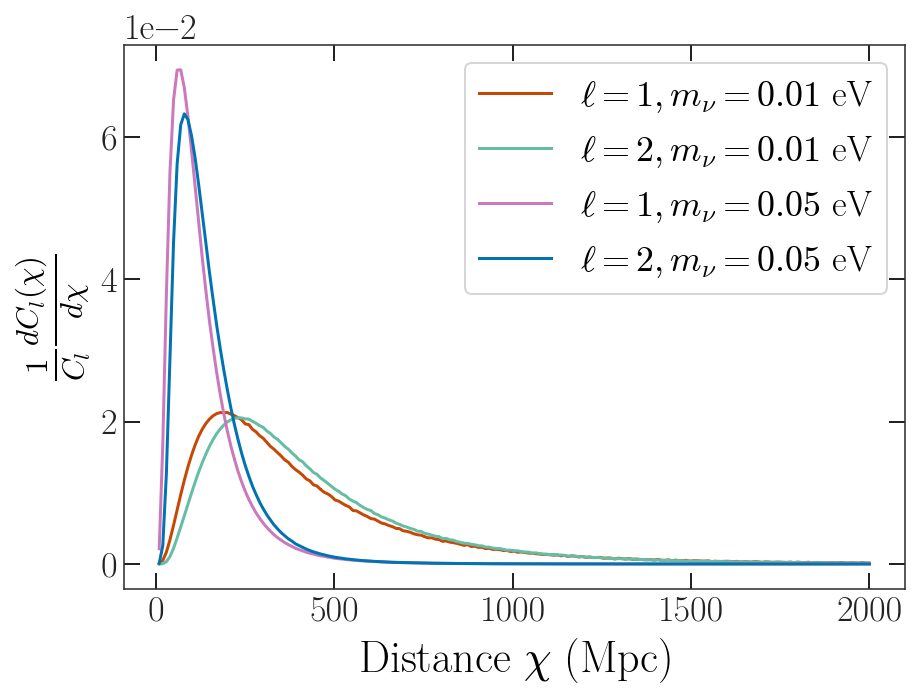

In [15]:
plt.figure(figsize=(7,5))
cls1_diss_l1pdf = np.array(cls1_diss_l1[1:])-np.array(cls1_diss_l1[:len(cls1_diss_l1)-1])
cls1_diss_l2pdf = np.array(cls1_diss_l2[1:])-np.array(cls1_diss_l2[:len(cls1_diss_l2)-1])
cls2_diss_l1pdf = np.array(cls2_diss_l1[1:])-np.array(cls2_diss_l1[:len(cls2_diss_l1)-1])
cls2_diss_l2pdf = np.array(cls2_diss_l2[1:])-np.array(cls2_diss_l2[:len(cls2_diss_l2)-1])

# normalization changes with nu_i 
plt.plot(distance_cutoffs1[1:], cls1_diss_l1pdf/clslos1_full[0], label=r'$\ell = 1, m_\nu={}$ eV'.format(nu_masses_str[nu_i]), 
         color=colors[0], marker=',')
plt.plot(distance_cutoffs1[1:], cls1_diss_l2pdf/clslos1_full[1], label=r'$\ell = 2, m_\nu={}$ eV'.format(nu_masses_str[nu_i]), 
         color=colors[1], marker=',')
plt.plot(distance_cutoffs2[1:], cls2_diss_l1pdf/clslos2_full[0], label=r'$\ell = 1, m_\nu={}$ eV'.format(nu_masses_str[nu_i2]), 
         color=colors[2], marker=',')
plt.plot(distance_cutoffs2[1:], cls2_diss_l2pdf/clslos2_full[1], label=r'$\ell = 2, m_\nu={}$ eV'.format(nu_masses_str[nu_i2]), 
         color=colors[4], marker=',')

plt.xlabel(r'Distance $\chi$ (Mpc)')
plt.ylabel(r'$\frac{1}{C_l}\frac{d C_l(\chi)}{d \chi}$')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.legend()

In [16]:
# get the Cls at different q values 

clqs_matrix = []
l_high = 21

for l in range(1, l_high):
    cl_q = []
    
    for i in range(0, n_qbins): 
        cl = uts.get_clq_LoS(2, i, pts_full, tf, nu_masses, True, k_magnitudes_full, [l], tau_0_full, np.infty)
        cl_q.append(cl[0])
        
    if (l == 1): 
        clqs_matrix = cl_q
    else: 
        clqs_matrix = np.vstack([clqs_matrix, cl_q])

In [17]:
clsqindep_l = uts.get_clqindep(2, np.arange(n_qbins), pts_full, tf, nu_masses, k_magnitudes_full, np.arange(20)+1, tau_0_full)

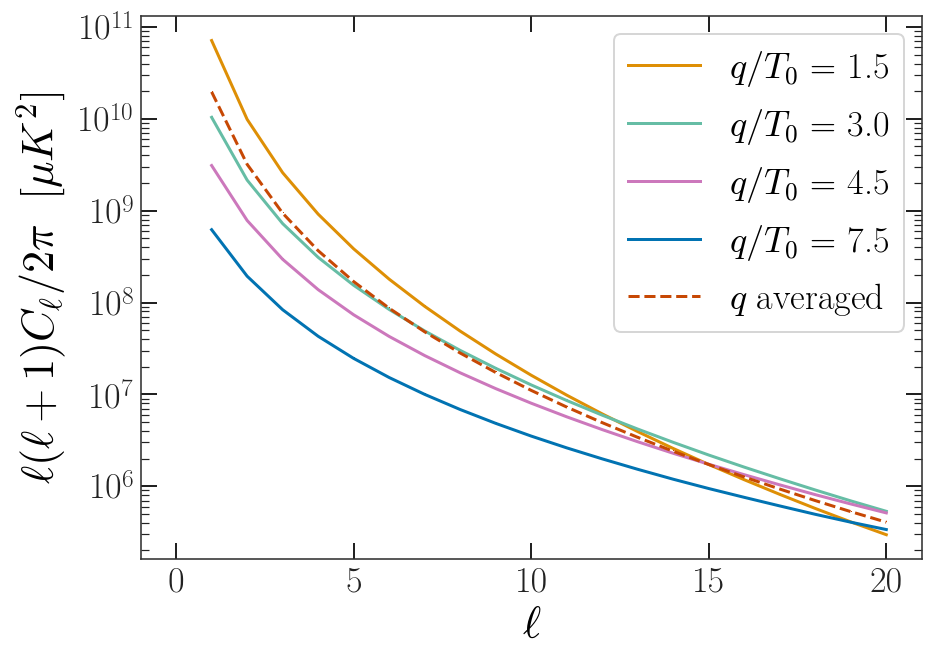

In [18]:
plt.figure(figsize=(7,5))

plt.semilogy(np.arange(1,l_high,1), np.arange(1,l_high,1)*np.arange(2,l_high+1,1)*clqs_matrix.T[0]/2/np.pi, 
             label=r'$q/T_0$ = 1.5', color=colors[3], marker=',')
plt.semilogy(np.arange(1,l_high,1), np.arange(1,l_high,1)*np.arange(2,l_high+1,1)*clqs_matrix.T[1]/2/np.pi, 
             label=r'$q/T_0$ = 3.0', color=colors[1], marker=',')
plt.semilogy(np.arange(1,l_high,1), np.arange(1,l_high,1)*np.arange(2,l_high+1,1)*clqs_matrix.T[2]/2/np.pi, 
             label=r'$q/T_0$ = 4.5', color=colors[2], marker=',')
plt.semilogy(np.arange(1,l_high,1), np.arange(1,l_high,1)*np.arange(2,l_high+1,1)*clqs_matrix.T[4]/2/np.pi, 
             label=r'$q/T_0$ = 7.5', color=colors[4], marker=',')
plt.semilogy(np.arange(1,l_high,1), np.arange(1,l_high,1)*np.arange(2,l_high+1,1)*clsqindep_l/2/np.pi, 
             label=r'$q$ averaged', color=colors[0], marker=',', linestyle='--')

plt.xlim(-1, 21)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi \ \ [\mu K^2]$')
plt.legend()

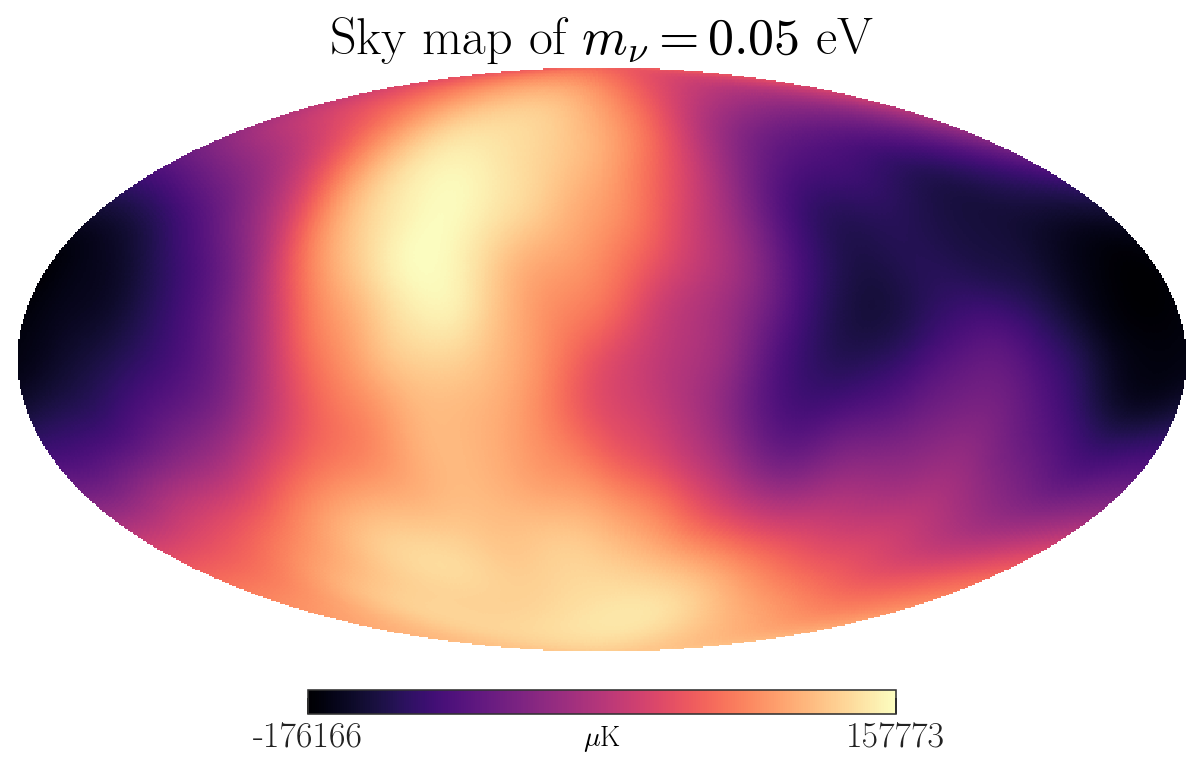

In [20]:
# add the monopole term as 0
cl_maps = np.concatenate((clsqindep_l, [0]))
cl_maps = np.roll(cl_maps, 1)

nside = 128 
nside_coarse = 4 
np.random.seed(5)  # fixes the map, otherwise it's random 
maps = hp.sphtfunc.synfast(cl_maps, nside=nside, lmax=None, pol=False)
hp.mollview(maps, title=r'Sky map of $m_\nu=0.05$ eV', unit=r'$\mu$K')

In [21]:
# convert cartesian to spherical coordinates 
NPIX = hp.nside2npix(nside)
ipix = np.arange(NPIX)
theta, phi = hp.pix2ang(nside=nside,ipix=ipix)

# get the observation spots coordinates 
thetas_N, phis_N = hp.pix2ang(nside=nside_coarse,ipix=np.arange(hp.nside2npix(nside_coarse)))

# split the map values by their theta values 
theta_vals, theta_inds = np.unique(theta, return_index=True)
maps_split = np.split(maps, theta_inds[1:])
phi_split = np.split(phi, theta_inds[1:])

In [22]:
qs = np.arange(1.5, 1.5*(n_qbins+1), 1.5)

rates = []  # rates integral without the constant coefficients 
norms = []  # normalizaiton without the constant coefficients 

# integral in eq (4.6) 
for theta_N, phi_N in zip(thetas_N, phis_N):
    integrals_q = []
    norms_q = []
    
    # loop for q integration 
    for q in qs:  
        gamma_q = -q/(np.exp(q)+1)*np.exp(q)
        
        integrals_theta = []
        norms_theta = []
        
        # loop for theta integration 
        for i, theta_val in enumerate(theta_vals):
            phis = phi_split[i] 
            maps_theta = maps_split[i]/(T_nu*1e6)  # scale for microK unit 
            cosa_theta = np.sin(theta_N)*np.sin(theta_val)*np.cos(phi_N - phis)+np.cos(theta_N)*np.cos(theta_val)
            alpha_theta = np.arccos(cosa_theta)
            dphi = phis[1:]-phis[:-1]
            
            # integrate over phi 
            integral_theta = np.sum(np.sin(theta_val)*(1+0.5*(cosa_theta[1:]+cosa_theta[:-1]))*(1 - gamma_q*0.5*(maps_theta[1:]+maps_theta[:-1]))*dphi)
            #integral_theta = np.sum(np.sin(theta_val)*np.exp(-alpha_theta[1:]**2/0.01)*(1 - gamma_q*0.5*(maps_theta[1:]+maps_theta[:-1]))*dphi)
            norm_theta = np.sum(np.sin(theta_val)*dphi)
            
            integrals_theta.append(integral_theta)
            norms_theta.append(norm_theta)

        # convert to np.array to allow for easy array calculations 
        integrals_theta = np.array(integrals_theta)
        norms_theta = np.array(norms_theta)
        
        # integrate over theta 
        dtheta = theta_vals[1:]-theta_vals[:-1] 
        integral_q = np.sum(0.5*(integrals_theta[1:]+integrals_theta[:-1])*dtheta)
        integrals_q.append(integral_q)
        
        norm_q = np.sum(0.5*(norms_theta[1:]+norms_theta[:-1])*dtheta)
        norms_q.append(norm_q)
    
    integrals_q = np.array(integrals_q)
    norms_q = np.array(norms_q)
    
    # integrate over q 
    dq = qs[1:]-qs[:-1] 
    q_centers = 0.5*(qs[1:]+qs[:-1])
    rate = np.sum((1+q_centers*k_B*T_nu/nu_masses[2])*q_centers**2/(np.exp(q_centers) + 1)*0.5*(integrals_q[1:]+integrals_q[:-1])*dq)
    norm = np.sum((1+q_centers*k_B*T_nu/nu_masses[2])*q_centers**2/(np.exp(q_centers) + 1)*0.5*(norms_q[1:]+norms_q[:-1])*dq)
    rates.append(rate)
    norms.append(norm)

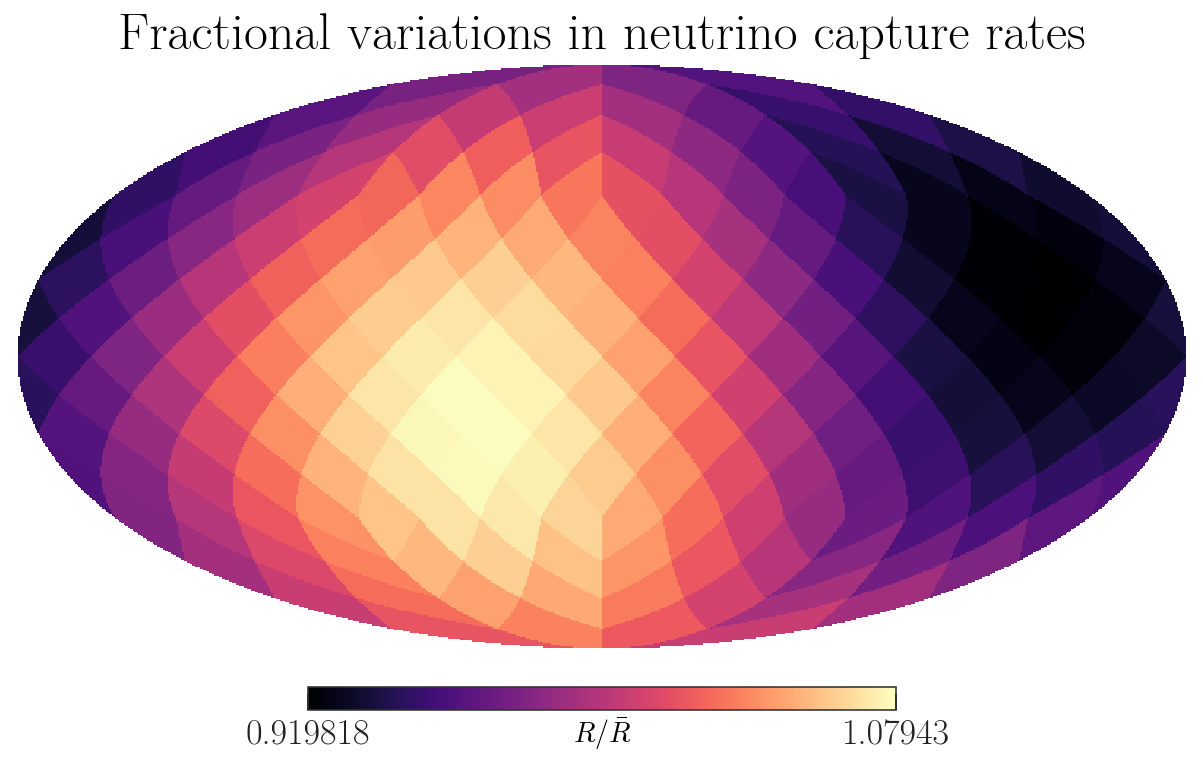

In [23]:
hp.mollview(np.array(rates)/np.array(norms), title='Fractional variations in neutrino capture rates', unit=r'$R/\bar{R}$')